In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import pandas as pd

palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='whitegrid', font="cmr10", font_scale=1.0)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [123]:
class Environment():
    def __init__(self, sid, t_cue=0.5, t_reward=0.5, dt=0.001, k=1, omega_0=0.4, alpha_omega=0.3, gamma_omega=0.1):
        self.empirical = pd.read_pickle("data/empirical.pkl")
        self.sid = sid
        self.t_cue = t_cue
        self.t_reward = t_reward
        self.dt = dt
        self.omega_0 = omega_0
        self.k = k
        self.omega_0sig = (1 / self.k) * np.log((1 - self.omega_0) / self.omega_0)
        self.alpha_omega = alpha_omega
        self.gamma_omega = gamma_omega
        self.letter  = [0,0]  # [A=-1, B=1]
        self.location = [0,0]  # [left=-1, right=1]
        self.omega = omega_0    # 0 to 1; 0.5 is equal arbitration
        self.reward = [0,0]
        self.action = [0,0]
        self.v_chosen = [0,0]
        self.feedback_phase = 0
        self.cue_phase = 0
    def set_cue(self, bid, trial):
        sid = self.sid
        left = self.empirical.query("sid==@sid & bid==@bid & trial==@trial")['left'].to_numpy()[0]
        right = self.empirical.query("sid==@sid & bid==@bid & trial==@trial")['right'].to_numpy()[0]
        self.letter  = [-1, 1] if (left=='A' and right=='B') else [1, -1]
        self.location = [-1, 1]
        self.reward = [0,0]
        self.action = [1,1]  # prevents learning during cue phase
        self.v_chosen = [0,0]
        self.cue_phase = 1
        self.feedback_phase = 0
    def set_action(self, sim, net):
        act = sim.data[net.p_action][-1]
        self.action = [1, 0] if act[0]>act[1] else [0,1]
    def set_omega(self, sim, net):
        chosen = 0 if self.action==[1,0] else 1
        probe_value = net.p_value_left if chosen==0 else net.p_value_right
        v_c_letter = sim.data[probe_value][-1,0]
        v_c_location = sim.data[probe_value][-1,1]
        delta_reliability = v_c_letter - v_c_location
        if delta_reliability > 0:
            self.omega += delta_reliability * self.alpha_omega * (1 - self.omega) + self.gamma_omega * (self.omega_0 - self.omega)
        else:
            self.omega += np.abs(delta_reliability) * self.alpha_omega * (0 - self.omega) + self.gamma_omega * (self.omega_0 - self.omega)
    def set_reward(self, bid, trial):
        block = self.empirical.query("sid==@sid & bid==@bid & trial==@trial")['block'].to_numpy()[0]
        correct = self.empirical.query("sid==@sid & bid==@bid & trial==@trial")['correct'].to_numpy()[0]
        if self.action == [1,0] and correct=='left': 
            self.reward = [1,0]
        if self.action == [0,1] and correct=='right': 
            self.reward = [0,1]
        if self.action == [1,0] and correct=='right': 
            self.reward = [-1,0]
        if self.action == [0,1] and correct=='left': 
            self.reward = [0,-1]
        self.cue_phase = 0
        self.feedback_phase = 1
    def set_v_chosen(self, sim, net):
        chosen = 0 if self.action==[1,0] else 1
        probe_value = net.p_value_left if chosen==0 else net.p_value_right
        v_c_letter = sim.data[probe_value][-1,0]
        v_c_location = sim.data[probe_value][-1,1]
        self.v_chosen = [v_c_letter, v_c_location]
    def sample_letter(self, t):
        return self.letter
    def sample_location(self, t):
        return self.location
    def sample_omega(self, t):
        return self.omega
    def sample_reward(self, t):
        return self.reward
    def sample_action(self, t):
        return self.action
    def sample_unchosen(self, t):
        return [1-self.action[0], 1-self.action[1]]
    def sample_phase(self, t):
        return [self.cue_phase, self.feedback_phase]
    def sample_v_chosen(self, t):
        return [self.v_chosen[0], self.v_chosen[1]]

In [124]:
def build_network(env, n_neurons=1000, seed_network=0, inh=0, k=0.2, a=4e-5):
    net = nengo.Network(seed=seed_network)
    net.env = env
    net.config[nengo.Connection].synapse = 0.01
    net.config[nengo.Probe].synapse = 0.1
    w_fb = np.array([[1, inh], [inh, 1]])
    inh_feedback = -1000*np.ones((n_neurons, 1))
    pes = nengo.PES(learning_rate=a)
    def shifted_sigmoid(x, k, x0):
        return 1 / (1 + np.exp(-k * (x - x0)))

    with net:
        in_letter = nengo.Node(lambda t: env.sample_letter(t))
        in_location = nengo.Node(lambda t: env.sample_location(t))
        in_omega = nengo.Node(lambda t: env.omega_0)
        in_reward = nengo.Node(lambda t: env.sample_reward(t))
        in_phase = nengo.Node(lambda t: env.sample_phase(t))
        in_unchosen = nengo.Node(lambda t: env.sample_unchosen(t))
        in_v_chosen = nengo.Node(lambda t: env.sample_v_chosen(t))
        target_omega = nengo.Node(lambda t: env.sample_omega(t))
        stop_load = nengo.Node(lambda t: 1 if t>1 else 0)
        
        letter = nengo.Ensemble(n_neurons, 2, radius=2)
        location = nengo.Ensemble(n_neurons, 2, radius=2)
        omega = nengo.Ensemble(n_neurons, 1)
        omega_norm = nengo.Ensemble(n_neurons, 1)
        value_left = nengo.Ensemble(n_neurons, 3, radius=3)
        value_right = nengo.Ensemble(n_neurons, 3, radius=3)
        weighted_value_left = nengo.Ensemble(n_neurons, 1)
        weighted_value_right = nengo.Ensemble(n_neurons, 1)
        # weighted_value_left = nengo.Ensemble(n_neurons, 1, encoders=nengo.dists.Choice([[1]]), intercepts=nengo.dists.Uniform(0, 1))
        # weighted_value_right = nengo.Ensemble(n_neurons, 1, encoders=nengo.dists.Choice([[1]]), intercepts=nengo.dists.Uniform(0, 1))
        reward = nengo.Ensemble(n_neurons, 2)
        action = nengo.Ensemble(n_neurons, 2)
        error = nengo.Ensemble(n_neurons, 2)
        load = nengo.Ensemble(n_neurons, 1)
        load2 = nengo.Ensemble(n_neurons, 1)
        delta_rel = nengo.Ensemble(n_neurons, 1)
        
        nengo.Connection(in_letter, letter, synapse=None)
        nengo.Connection(in_location, location, synapse=None)
        nengo.Connection(in_reward, reward, synapse=None)

        # load omega_0 into omega (integrator)
        # nengo.Connection(in_omega, load, synapse=None)
        # nengo.Connection(omega, load, transform=-1)
        # nengo.Connection(load, omega)
        # nengo.Connection(stop_load, load.neurons, transform=inh_feedback)
        # nengo.Connection(in_omega, omega_norm, synapse=None)

        nengo.Connection(omega, omega, synapse=0.1)
        nengo.Connection(omega, omega_norm, function=lambda x: shifted_sigmoid(x, k=env.k, x0=env.omega_0sig))

        # update omega by Delta_Rel
        nengo.Connection(in_v_chosen[0], delta_rel)
        nengo.Connection(in_v_chosen[1], delta_rel, transform=-1)
        nengo.Connection(delta_rel, load2)
        nengo.Connection(load2, omega, transform=env.alpha_omega*0.2)
        nengo.Connection(in_phase[0], load2.neurons, transform=inh_feedback)
        
        c0 = nengo.Connection(letter[0], value_left[0], transform=0, learning_rule_type=pes)
        c1 = nengo.Connection(letter[1], value_right[0], transform=0, learning_rule_type=pes)
        c2 = nengo.Connection(location[0], value_left[1], transform=0, learning_rule_type=pes)
        c3 = nengo.Connection(location[1], value_right[1], transform=0, learning_rule_type=pes)
        nengo.Connection(omega_norm, value_left[2])
        nengo.Connection(omega_norm, value_right[2])

        nengo.Connection(value_left, weighted_value_left, function=lambda x: x[0]*x[2])
        nengo.Connection(value_left, weighted_value_left, function=lambda x: x[1]*(1-x[2]))
        nengo.Connection(value_right, weighted_value_right, function=lambda x: x[0]*x[2])
        nengo.Connection(value_right, weighted_value_right, function=lambda x: x[1]*(1-x[2]))
        
        nengo.Connection(weighted_value_left, action[0], transform=k)
        nengo.Connection(weighted_value_right, action[1], transform=k)
        nengo.Connection(action, action, transform=w_fb, synapse=0.1)

        nengo.Connection(in_phase[0], error.neurons, transform=inh_feedback, synapse=None)
        nengo.Connection(in_phase[1], action.neurons, transform=inh_feedback, synapse=None)
        nengo.Connection(in_unchosen[0], value_left.neurons, transform=inh_feedback, synapse=None)
        nengo.Connection(in_unchosen[1], value_right.neurons, transform=inh_feedback, synapse=None)

        nengo.Connection(reward, error, transform=+1)
        nengo.Connection(value_left[0], error[0], transform=-1)
        nengo.Connection(value_left[1], error[0], transform=-1)
        nengo.Connection(value_right[0], error[1], transform=-1)
        nengo.Connection(value_right[1], error[1], transform=-1)

        nengo.Connection(error[0], c0.learning_rule, transform=-1)
        nengo.Connection(error[0], c2.learning_rule, transform=-1)
        nengo.Connection(error[1], c1.learning_rule, transform=-1)
        nengo.Connection(error[1], c3.learning_rule, transform=-1)
    
        net.p_letter = nengo.Probe(letter)
        net.p_location = nengo.Probe(location)
        net.p_value_left = nengo.Probe(value_left)
        net.p_value_right = nengo.Probe(value_right)
        net.p_weighted_value_left = nengo.Probe(weighted_value_left)
        net.p_weighted_value_right = nengo.Probe(weighted_value_right)
        net.p_reward = nengo.Probe(reward)
        net.p_action = nengo.Probe(action)
        net.p_error = nengo.Probe(error)
        net.p_delta_rel = nengo.Probe(delta_rel)
        net.p_omega = nengo.Probe(omega)
        net.p_omega_norm = nengo.Probe(omega_norm)
        net.p_omega_target = nengo.Probe(target_omega)

    return net

In [125]:
def plot_network(net, bid=1, trials=10):
    sim = nengo.Simulator(net, dt=net.env.dt, progress_bar=False)    
    with sim:
        for trial in net.env.empirical.query("sid==@sid & bid==@bid")['trial'].unique()[:trials]:
            print(f"running sid {net.env.sid}, block {bid}, trial {trial}")
            net.env.set_cue(bid, trial)
            sim.run(net.env.t_cue)
            env.set_action(sim, net)
            env.set_omega(sim, net)
            env.set_reward(bid, trial)
            env.set_v_chosen(sim, net)
            sim.run(net.env.t_reward)
    return sim

In [126]:
def simulate_network(net):
    dfs = []
    columns = ['sid', 'bid', 'trial', 'trial_after_reversal', 'accuracy']
    sim = nengo.Simulator(net, dt=net.env.dt, progress_bar=False)    
    with sim:
        for bid in net.env.empirical.query("sid==@sid")['bid'].unique():
            for trial in net.env.empirical.query("sid==@sid & bid==@bid")['trial'].unique():
                print(f"running sid {net.env.sid}, block {bid}, trial {trial}")
                net.env.set_cue(bid, trial)
                sim.run(net.env.t_cue)
                env.set_action(sim, net)
                env.set_omega(sim, net)
                env.set_reward(bid, trial)
                env.set_v_chosen(sim, net)
                sim.run(net.env.t_reward)
                accuracy = 1 if np.sum(env.reward)==1 else 0
                sid = env.sid
                reversal_at_trial = net.env.empirical.query("sid==@sid & bid==@bid")['reversal_at_trial'].unique()[0]
                trial_after_reversal = int(trial) - int(reversal_at_trial)
                dfs.append(pd.DataFrame([[sid, bid, trial, trial_after_reversal, accuracy]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    return sim, data

## Dynamics

In [132]:
sid = 1
bid = 5
env = Environment(sid=sid)
net = build_network(env)
sim = plot_network(net, bid=bid, trials=40)

running sid 1, block 5, trial 1
running sid 1, block 5, trial 2
running sid 1, block 5, trial 3
running sid 1, block 5, trial 4
running sid 1, block 5, trial 5
running sid 1, block 5, trial 6
running sid 1, block 5, trial 7
running sid 1, block 5, trial 8
running sid 1, block 5, trial 9
running sid 1, block 5, trial 10
running sid 1, block 5, trial 11
running sid 1, block 5, trial 12
running sid 1, block 5, trial 13
running sid 1, block 5, trial 14
running sid 1, block 5, trial 15
running sid 1, block 5, trial 16
running sid 1, block 5, trial 17
running sid 1, block 5, trial 18
running sid 1, block 5, trial 19
running sid 1, block 5, trial 20
running sid 1, block 5, trial 21
running sid 1, block 5, trial 22
running sid 1, block 5, trial 23
running sid 1, block 5, trial 24
running sid 1, block 5, trial 25
running sid 1, block 5, trial 26
running sid 1, block 5, trial 27
running sid 1, block 5, trial 28
running sid 1, block 5, trial 29
running sid 1, block 5, trial 30
running sid 1, bloc

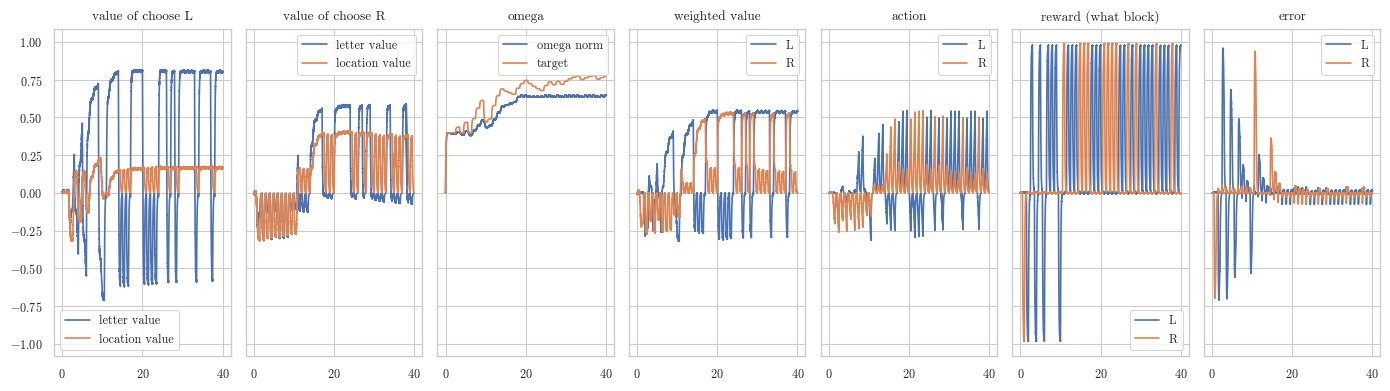

In [133]:
fig, axes = plt.subplots(nrows=1, ncols=7, sharey=True, figsize=(14, 4))
axes[0].plot(sim.trange(), sim.data[net.p_value_left][:,0], label='letter value')
axes[0].plot(sim.trange(), sim.data[net.p_value_left][:,1], label='location value')
axes[1].plot(sim.trange(), sim.data[net.p_value_right][:,0], label='letter value')
axes[1].plot(sim.trange(), sim.data[net.p_value_right][:,1], label='location value')
# axes[2].plot(sim.trange(), sim.data[net.p_omega], label='omega')
axes[2].plot(sim.trange(), sim.data[net.p_omega_norm], label='omega norm')
axes[2].plot(sim.trange(), sim.data[net.p_omega_target], label='target')
# axes[2].plot(sim.trange(), sim.data[net.p_delta_rel], label='delta_rel')
axes[3].plot(sim.trange(), sim.data[net.p_weighted_value_left], label='L')
axes[3].plot(sim.trange(), sim.data[net.p_weighted_value_right], label='R')
axes[4].plot(sim.trange(), sim.data[net.p_action][:,0], label='L')
axes[4].plot(sim.trange(), sim.data[net.p_action][:,1], label='R')
axes[5].plot(sim.trange(), sim.data[net.p_reward][:,0], label='L')
axes[5].plot(sim.trange(), sim.data[net.p_reward][:,1], label='R')
axes[6].plot(sim.trange(), sim.data[net.p_error][:,0], label='L')
axes[6].plot(sim.trange(), sim.data[net.p_error][:,1], label='R')
axes[0].set(title='value of choose L')
axes[1].set(title='value of choose R')
axes[2].set(title='omega')
axes[3].set(title='weighted value')
axes[4].set(title='action')
block = net.env.empirical.query("sid==@sid & bid==@bid")['block'].to_numpy()[0]
axes[5].set(title=f'reward ({block} block)')
axes[6].set(title='error')
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
axes[4].legend()
axes[5].legend()
axes[6].legend()
fig.tight_layout()

# fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(4, 2))
# axes[0].plot(sim.trange(), sim.data[net.p_letter], label='letter')
# axes[1].plot(sim.trange(), sim.data[net.p_location], label='location')
# axes[0].set(title="letter")
# axes[1].set(title="location")
# fig.tight_layout()

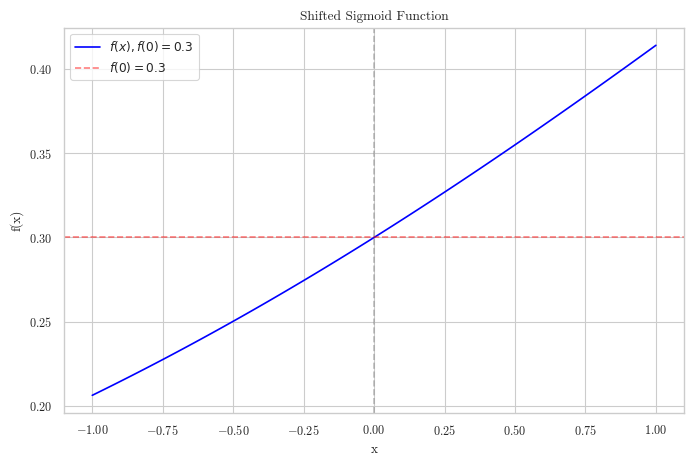

In [129]:
w = 0.3        # Desired value at x = 0
k = 0.5          # Steepness of the sigmoid

# Compute x0 to ensure f(0) = w
x0 = (1 / k) * np.log((1 - w) / w)

# Define the shifted sigmoid function
def shifted_sigmoid(x, k, x0):
    return 1 / (1 + np.exp(-k * (x - x0)))

# Generate x values and compute sigmoid
x_vals = np.linspace(-1, 1, 100)
y_vals = shifted_sigmoid(x_vals, k, x0)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, label=f'$f(x), f(0)={w}$', color='blue')
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(w, color='red', linestyle='--', alpha=0.5, label=f'$f(0) = {w}$')
plt.title('Shifted Sigmoid Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()

## All data

In [ ]:
sid = 1
env = Environment(sid=sid)
net = build_network(env)
sim, data = simulate_network(net)

## Simulate all behavioral data

In [ ]:
empirical = pd.read_pickle("data/empirical.pkl")
dfs = []
for sid in empirical['sid'].unique():
    env = Environment(sid=sid)
    net = build_network(env)
    sim, data = simulate_network(net)
    dfs.append(data)
simulated = pd.concat(dfs, ignore_index=True)
simulated.to_pickle("data/simulated.pkl")

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharey=True)
sns.lineplot(data, x='trial', y='accuracy', ax=axes[0])
sns.lineplot(data, x='trial_after_reversal', y='accuracy', ax=axes[1])
fig.tight_layout()